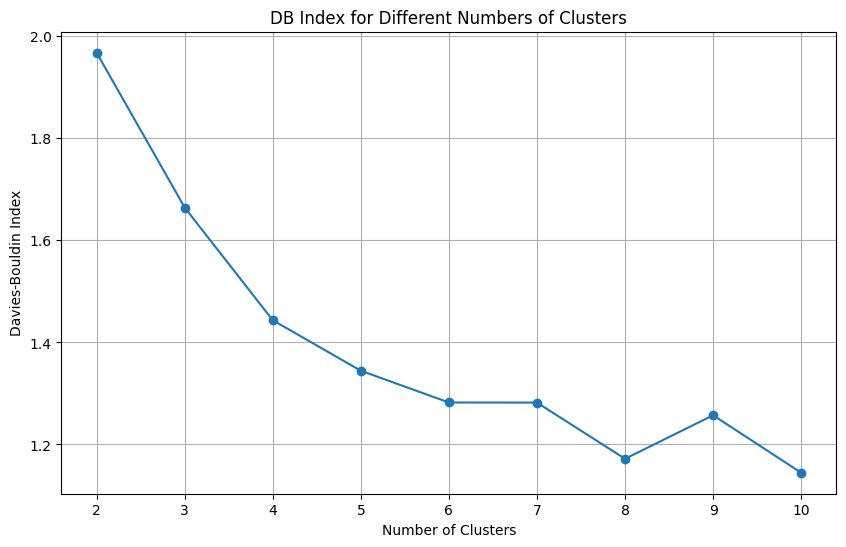

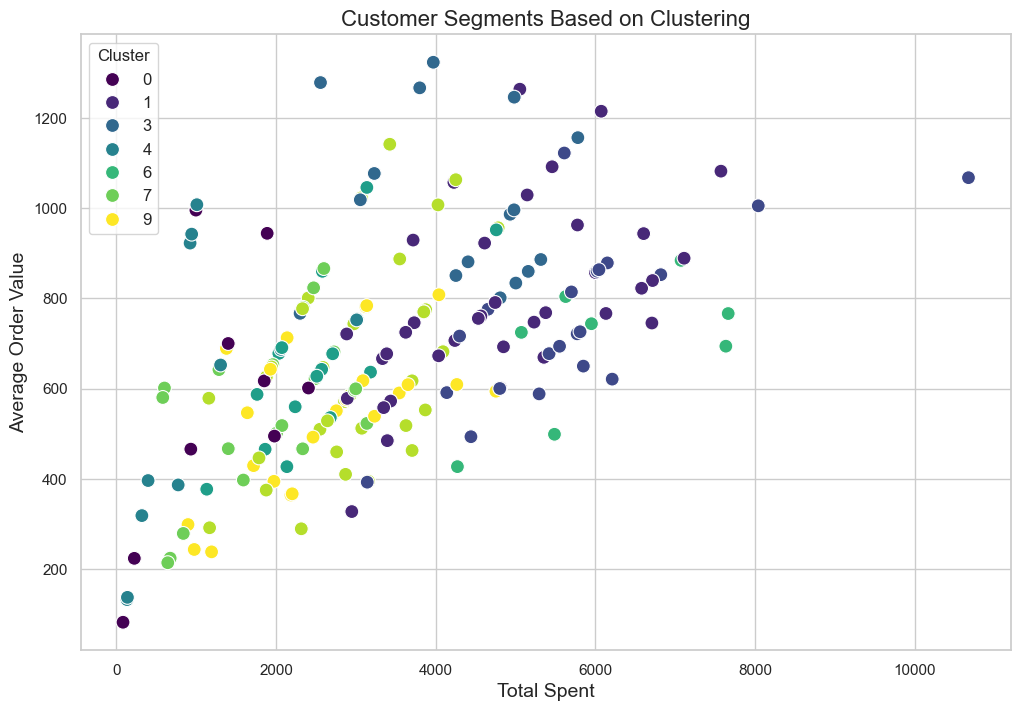

Optimal number of clusters: 10


In [2]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv('Customers.csv.csv')
products = pd.read_csv('Products.csv.csv')
transactions = pd.read_csv('Transactions.csv.csv')

# Preprocess data
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Merge datasets
transactions_products = transactions.merge(products, on='ProductID', how='left')
full_data = transactions_products.merge(customers, on='CustomerID', how='left')

# Aggregate customer-level features
customer_aggregates = (
    full_data.groupby('CustomerID')
    .agg(
        TotalSpent=('TotalValue', 'sum'),
        TotalTransactions=('TransactionID', 'count'),
        AverageOrderValue=('TotalValue', 'mean'),
        FirstPurchase=('TransactionDate', 'min'),
        LastPurchase=('TransactionDate', 'max'),
        Region=('Region', 'first')
    )
    .reset_index()
)

# Calculate recency and tenure
customer_aggregates['Recency'] = (full_data['TransactionDate'].max() - customer_aggregates['LastPurchase']).dt.days
customer_aggregates['Tenure'] = (full_data['TransactionDate'].max() - customer_aggregates['FirstPurchase']).dt.days

# One-hot encode the Region column
customer_aggregates = pd.get_dummies(customer_aggregates, columns=['Region'], drop_first=True)

# Prepare data for clustering
clustering_data = customer_aggregates.drop(columns=['CustomerID', 'FirstPurchase', 'LastPurchase'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

# Perform clustering and evaluate using DB Index
db_scores = []
range_n_clusters = range(2, 11)
cluster_results = {}

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, cluster_labels)
    db_scores.append(db_index)
    cluster_results[n_clusters] = cluster_labels

# Optimal number of clusters
optimal_clusters = range_n_clusters[np.argmin(db_scores)]

# Plot DB Index for different cluster counts
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, db_scores, marker='o')
plt.title('DB Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.xticks(range_n_clusters)
plt.grid()
plt.show()

# Assign the optimal clustering labels
customer_aggregates['Cluster'] = cluster_results[optimal_clusters]

# Visualize clusters (example with TotalSpent and AverageOrderValue)
sns.set(style='whitegrid')
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=customer_aggregates, 
    x='TotalSpent', 
    y='AverageOrderValue', 
    hue='Cluster', 
    palette='viridis', 
    s=100
)
plt.title('Customer Segments Based on Clustering', fontsize=16)
plt.xlabel('Total Spent', fontsize=14)
plt.ylabel('Average Order Value', fontsize=14)
plt.legend(title='Cluster', fontsize=12)
plt.show()

# Save the clustered data to a CSV file
customer_aggregates.to_csv('Customer_Segments.csv', index=False)

print(f"Optimal number of clusters: {optimal_clusters}")


In [3]:
# Save the clustered data to a CSV file
customer_aggregates.to_csv("Customer_Segments.csv", index=False)

print(f"Optimal number of clusters: {optimal_clusters}")

Optimal number of clusters: 10


In [10]:
import pandas as pd

# Create a simple clustering DataFrame (adjust according to your clustering results)
clustering_data = {
    'CustomerID': ['C0001', 'C0002', 'C0003', 'C0004', 'C0005'],  # Example Customer IDs
    'Cluster': [1, 2, 1, 3, 2],  # Example cluster assignments
    'Score': [0.85, 0.90, 0.80, 0.75, 0.88]  # Example similarity score or any other metric
}

# Create DataFrame
clustering_df = pd.DataFrame(clustering_data)

# Print DataFrame to verify its contents
print(clustering_df)

# Save the DataFrame to an Excel file with a new name
clustering_df.to_excel('Customer_Segmentation_Results.xlsx', index=False)


  CustomerID  Cluster  Score
0      C0001        1   0.85
1      C0002        2   0.90
2      C0003        1   0.80
3      C0004        3   0.75
4      C0005        2   0.88
